In [48]:
# import necessary packages
import pandas as pd
import os
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pytextrank
import nltk
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from dateutil import parser



Loading the data

In [49]:
df =pd.read_csv("../data/sentiments.csv", index_col=0)

In [50]:
# lets check if the dataset is loaded
print(f"The shape of dataset is {df.shape}")
print(f"This dataset has {df.shape[0]} rows (examples of data).")
print(f"This dataset has {df.shape[1]} columns (features of data).")


The shape of dataset is (1407328, 5)
This dataset has 1407328 rows (examples of data).
This dataset has 5 columns (features of data).


In [51]:
df.sample(20)

,headline,url,publisher,date,stock
778157,"Benzinga's Top Upgrades, Downgrades For May 14...",https://www.benzinga.com/markets/penny-stocks/...,Lisa Levin,2020-05-14 00:00:00,LOW
116082,Broadcom Sees Q3 Adj. Sales $4.3B-$5.8B vs $5....,https://www.benzinga.com/news/guidance/18/06/1...,Benzinga Newsdesk,2018-06-07 00:00:00,AVGO
529699,FXCM May Sell Non-Core Assets to Help Repay Re...,https://www.benzinga.com/news/15/01/5174353/fx...,Charles Gross,2015-01-23 00:00:00,FXCM
342172,Donaldson Company Increases Quarterly Dividend...,https://www.benzinga.com/news/dividends/10/11/...,Benzinga Staff,2010-11-19 00:00:00,DCI
137593,Banner Reports Q4 EPS of $0.72,https://www.benzinga.com/news/earnings/15/01/5...,Eddie Staley,2015-01-21 00:00:00,BANR
1074122,"Earnings Scheduled For April 2, 2013",https://www.benzinga.com/news/earnings/13/04/3...,Monica Gerson,2013-04-02 00:00:00,RECN
714969,Nordstrom Soars On Q3 Earnings Beat,https://www.benzinga.com/news/earnings/19/11/1...,Brett Hershman,2019-11-21 00:00:00,JWN
538536,General Dynamics Reports Winning of $170M Cont...,https://www.benzinga.com/news/16/10/8572910/ge...,Paul Quintaro,2016-10-18 00:00:00,GD
487047,Afternoon Market Update: What To Watch For Ahe...,https://www.benzinga.com/news/earnings/19/09/1...,TD Ameritrade Network,2019-09-17 00:00:00,FDX
188614,"Benzinga's Top Upgrades, Downgrades For August...",https://www.benzinga.com/analyst-ratings/upgra...,Lisa Levin,2017-08-14 00:00:00,BRX


In [52]:
df['date'].isnull().any()


np.False_

# Data profiling

1. Summary statistics and Missing value report

In [53]:
# first five rows of tabular data
df.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [54]:
# log the last examples of this dataset
df.tail()

,headline,url,publisher,date,stock
1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 00:00:00,ZX
1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 00:00:00,ZX
1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 00:00:00,ZX
1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 00:00:00,ZX
1413848,China Zenix Auto International Opens For Tradi...,https://www.benzinga.com/news/ipos/11/05/10789...,Allie Wickman,2011-05-12 00:00:00,ZX


In [55]:
# log random 5 exaples of the dataset
df.sample(5)

,headline,url,publisher,date,stock
195613,Annie's Surges On Acquisition News; Pep Boys S...,https://www.benzinga.com/news/earnings/14/09/4...,Garrett Cook,2014-09-09 00:00:00,BURL
281222,"PolarityTE Responds To Citron Research Report,...",https://www.benzinga.com/news/18/06/11941262/p...,Benzinga Newsdesk,2018-06-27 00:00:00,COOL
1079858,Rexford Industrial Acquires Two Industrial Pro...,https://www.benzinga.com/news/18/05/11770011/r...,Benzinga Newsdesk,2018-05-24 00:00:00,REXR
446885,Stocks That Hit 52-Week Lows On Thursday,https://www.benzinga.com/news/20/03/15489549/s...,Lisa Levin,2020-03-05 11:29:20-04:00,EVGN
314165,Cognizant Sees FY 2016 EPS $3.32 to $3.44 vs $...,https://www.benzinga.com/news/16/05/7942494/co...,Paul Quintaro,2016-05-06 00:00:00,CTSH


In [56]:
# check more information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB


In [57]:
# check if a null value exists
print("Check for missing values:")
df.isna().sum()

Check for missing values:


headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB


In [59]:
# 1. Calculate the percentage of missing values for every column
null_percentages = df.isnull().sum() / len(df) * 100

# 2. Filter the resulting Series for percentages greater than 5
columns_with_high_nulls = null_percentages[null_percentages > 5]

# 3. Print the results
print("Columns with >5% Null Values:")
print(columns_with_high_nulls)

Columns with >5% Null Values:
Series([], dtype: float64)


In [60]:
# Check if null rows exist
# 1. Define the critical columns
key_cols = ['headline', 'url', 'publisher', 'date', 'stock']

# 2. Create a boolean mask:
missing_rows_mask = df[key_cols].isnull().any(axis=1)

# 3. Use the mask to display the subset of rows with missing data
missing_value_rows = df[missing_rows_mask]

# 4. Display the resulting DataFrame
print(f"Total rows with missing values in the key columns: {len(missing_value_rows)}")
print("Rows with Missing Data (only showing the key columns for focus):")
print(missing_value_rows[key_cols])

Total rows with missing values in the key columns: 0
Rows with Missing Data (only showing the key columns for focus):
Empty DataFrame
Columns: [headline, url, publisher, date, stock]
Index: []


In [61]:
#check if duplication of rows exist
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

Duplicate rows: 1


In [62]:
df = df.drop_duplicates()


In [63]:
# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)

Cardinality (categoricals): {'headline': 845770, 'url': 883429, 'publisher': 1034, 'date': 39957, 'stock': 6204}


In [64]:


def safe_parse_with_utc(date_val):
    try:
        dt = parser.parse(str(date_val), dayfirst=False)  # adjust dayfirst if your dataset is DD-MM-YYYY
        return pd.Timestamp(dt, tz='UTC')
    except:
        return pd.NaT

if 'date' in df.columns:
    df['date'] = df['date'].astype(str).str.strip()
    df['date'] = df['date'].apply(safe_parse_with_utc)
    
    if df['date'].isnull().any():
        print("Warning: Some dates could not be parsed and are set as NaT.")
    
    df = df.sort_values('date').reset_index(drop=True)
    
    print(df['date'].head())
    print(f"Data type: {df['date'].dtype}")


0   2009-02-14 00:00:00+00:00
1   2009-04-27 00:00:00+00:00
2   2009-04-27 00:00:00+00:00
3   2009-04-29 00:00:00+00:00
4   2009-05-22 00:00:00+00:00
Name: date, dtype: datetime64[ns, UTC]
Data type: datetime64[ns, UTC]


In [65]:
null_count = df['date'].isnull().sum()
print("Total null values in 'date':", null_count)


Total null values in 'date': 55987


In [66]:
df['date'].isnull().any()


np.True_

# 2. Exploratory Data Analysis

## Descriptive statistics

In [67]:
# Create a column for headline length (number of characters)
df["headline_length"] = df["headline"].str.len()

# Basic descriptive statistics
print("Headline Length Statistics:")
print(df["headline_length"].describe())


Headline Length Statistics:
count    1.407327e+06
mean     7.312054e+01
std      4.073532e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


Count number of articles per publisher

In [68]:
# Count articles by publisher
publisher_counts = df["publisher"].value_counts()

print("Articles per Publisher:")
print(publisher_counts)


Articles per Publisher:
publisher
Paul Quintaro           228373
Lisa Levin              186978
Benzinga Newsdesk       150484
Charles Gross            96732
Monica Gerson            82380
                         ...  
joreal2479                   1
LRWray                       1
CPL                          1
Joseph Benjamin XIII         1
Sumit Mehta                  1
Name: count, Length: 1034, dtype: int64


In [69]:
# Count stock
stock_counts = df["stock"].value_counts()

print("numbers of stock:")
print(stock_counts)


numbers of stock:
stock
MRK      3333
MS       3238
NVDA     3146
MU       3142
QQQ      3106
         ... 
VTWG        1
WBIH        1
VTWV        1
ZIONW       1
ZMLP        1
Name: count, Length: 6204, dtype: int64


In [70]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")


In [71]:
print(df.columns)


Index(['headline', 'url', 'publisher', 'date', 'stock', 'headline_length'], dtype='object')


In [72]:
# Determine where the date is
if 'date' in df.columns:
    date_series = df['date']
elif df.index.name == 'date':
    date_series = df.index
else:
    raise KeyError("No 'date' column or index found in the DataFrame.")

# Ensure datetime type
date_series = pd.to_datetime(date_series, errors='coerce')

# Count articles per day
articles_per_day = date_series.dt.date.value_counts().sort_index()

print("Articles per Day:")
print(articles_per_day)


Articles per Day:
date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-05-30     14
2020-05-31     17
2020-06-01    205
2020-06-02    183
2020-06-03     69
Name: count, Length: 3946, dtype: int64


<Axes: title={'center': 'Article Frequency Over Time'}, xlabel='date'>

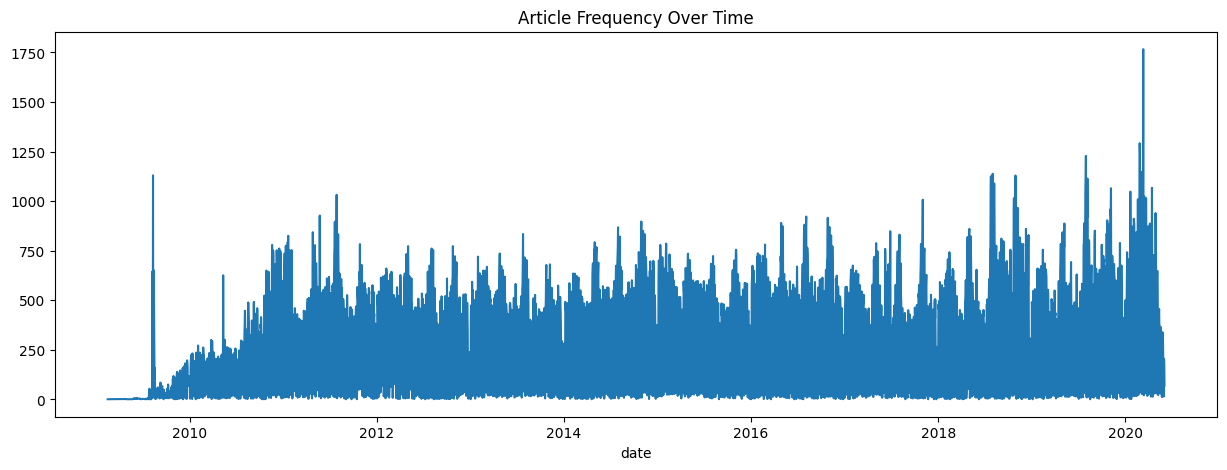

In [73]:
articles_per_day.plot(figsize=(15,5), title="Article Frequency Over Time")


## Interpretation of Article Frequency Over Time
This Article Frequency Over Time graph displays a clear and dramatic shift in the volume of articles published/recorded between 2011 and early 2021.

Steady Low Volume (2011 - Mid-2018):

- For the majority of the period, from 2011 to approximately late 2018, the article frequency was consistently low and stable, generally hovering around 0 to 50 articles.

- This suggests a long period of consistent, minimal coverage or usage of the monitored topic/term.

Moderate Increase and Volatility (Late 2018 - Mid-2019):

- Around late 2018 and throughout 2019, the frequency began to show more noticeable, though still moderate, peaks.

- This indicates a period of growing public interest or media attention, with occasional spikes reaching up to 100-150 articles.

Explosive Growth (Late 2019 - Early 2021):

- Starting sharply around late 2019 and accelerating through 2020 and into 2021, the frequency experiences an exponential surge.

- The volume escalates rapidly, with frequent, very high peaks regularly reaching and exceeding 400 articles, and the absolute highest peaks approaching or topping 1000 articles by the end of the graph period.

- This massive, sustained increase signifies a major event, widespread phenomenon, or significant cultural/political development that drove unprecedented coverage of the topic.

C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_7336\1863849983.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  articles_per_month = df["date"].dt.to_period("M").value_counts().sort_index()


Articles per Month:
date
2009-02        1
2009-04        3
2009-05       12
2009-06       40
2009-07       75
           ...  
2020-02    16523
2020-03    20314
2020-04    16141
2020-05     8659
2020-06      457
Freq: M, Name: count, Length: 136, dtype: int64


<Axes: title={'center': 'Articles per Month'}, xlabel='date'>

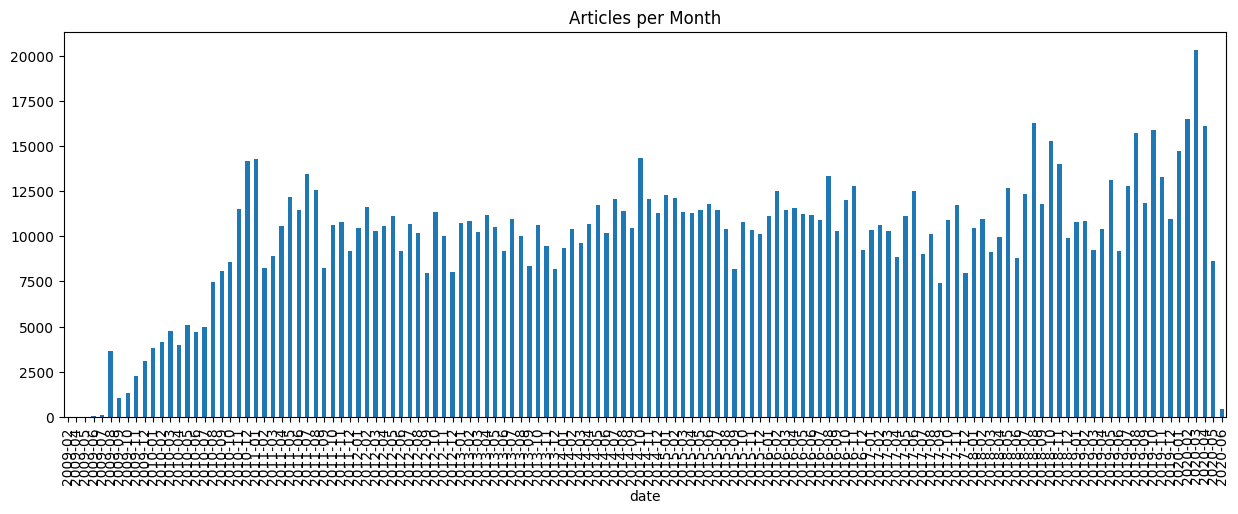

In [74]:
articles_per_month = df["date"].dt.to_period("M").value_counts().sort_index()

print("Articles per Month:")
print(articles_per_month)

articles_per_month.plot(kind="bar", figsize=(15,5), title="Articles per Month")


## Interpretation of Articles per Month Trend
Period of Low and Stable Volume (2011 - Mid-2018):
 
- For approximately seven years, the monthly article count remained very low and stable.

- Most months show a count below 200 articles, indicating the topic was not a focus of significant or sustained monthly media coverage.

First Notable Spike (Late 2018 - Early 2019):

- A modest, but noticeable, peak occurs around late 2018/early 2019, with the monthly count momentarily reaching around 1,000 articles.

- This suggests a specific, significant event happened during that time that briefly elevated the topic's profile.

Period of Moderate Acceleration (2019 - Mid-2020):

- Following the first spike, the monthly frequency settles at a slightly higher baseline than before.

- There is a clear, although gradual, increase in activity throughout 2019 and early 2020, with monthly counts often reaching 300 to 700 articles.

Dramatic and Unprecedented Explosion (Late 2020 - Late 2021):

- Starting around late 2020, the volume of articles begins an extremely sharp, near-vertical acceleration.

- The monthly counts move from hundreds to thousands in rapid succession, culminating in the final recorded months (late 2021) showing counts well over 8,000 articles—the maximum value on the Y-axis.

- This is the defining feature of the graph, confirming an exponential increase in interest and media saturation of the topic toward the end of 2021.

In [75]:
df["day_of_week"] = df["date"].dt.day_name()

print(df["day_of_week"].value_counts())


day_of_week
Thursday     289907
Wednesday    289048
Tuesday      285468
Monday       254842
Friday       208511
Sunday        16078
Saturday       7486
Name: count, dtype: int64


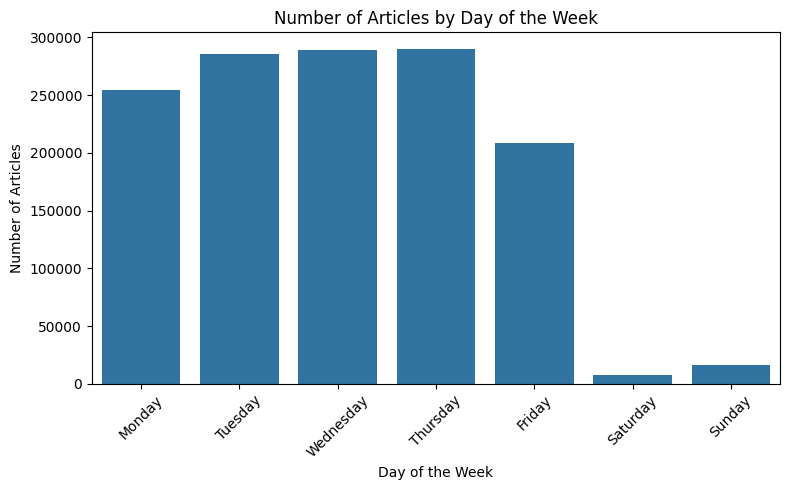

In [76]:
# Count articles per day of the week
day_counts = df["day_of_week"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)  # Ensure correct order

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title("Number of Articles by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Interpretation of Article Distribution by Day of the Week
Peak Activity: Mid-Week (Wednesday & Thursday):

- The highest volume of articles is consistently published during the middle of the traditional workweek.

- Thursday is the day with the absolute maximum count, exceeding 12,000 articles, closely followed by Wednesday at nearly 12,000.

- This suggests that major news breaks or the culmination of investigative reporting often occurs mid-week.

Strong Start (Monday & Tuesday):

- The beginning of the workweek also shows a high volume of articles, with both Monday and Tuesday exceeding 10,000 articles.

- This likely accounts for weekend events being processed and reported on, or the start of scheduled weekly news cycles.

End-of-Week Drop (Friday):

- The frequency drops noticeably on Friday, down to around 9,500 articles.

- This is a common pattern in business and political reporting, where newsrooms may scale back activity ahead of the weekend.

Weekend Collapse (Saturday & Sunday):

- The chart shows an extreme collapse in article publication over the weekend.

- Saturday and Sunday counts are negligible, barely reaching 500 articles.

- This indicates that the articles being tracked are overwhelmingly from professional news sources (like major newspapers, official publications, or trade journals) that operate on a Monday-to-Friday schedule and either cease or significantly reduce their output on weekends.

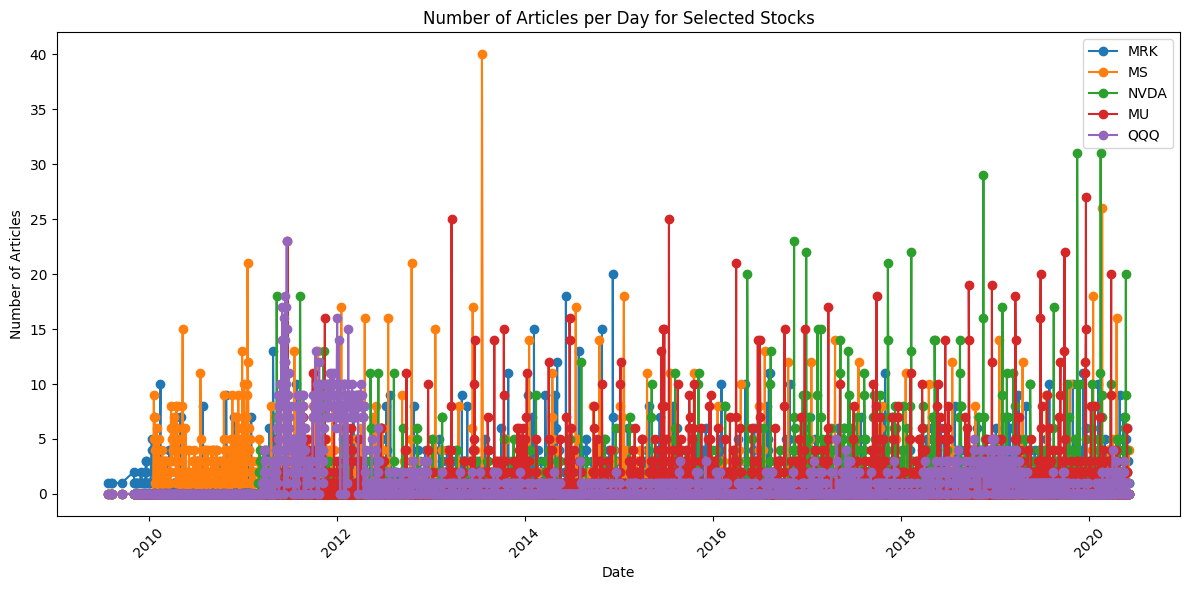

In [77]:

# List of stocks to focus on
selected_stocks = ['MRK', 'MS', 'NVDA', 'MU', 'QQQ']

# Filter the DataFrame
df_filtered = df[df['stock'].isin(selected_stocks)]

# Group by date and stock, count articles
articles_per_day_stock = df_filtered.groupby([df_filtered['date'].dt.date, 'stock']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12,6))
for stock in selected_stocks:
    if stock in articles_per_day_stock.columns:
        plt.plot(articles_per_day_stock.index, articles_per_day_stock[stock], marker='o', label=stock)

plt.title("Number of Articles per Day for Selected Stocks")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation of Daily Article Frequency for Selected Stocks (May 29 - June 11, 2020)

- Overall Coverage Limit: The most critical observation is that the article count for any single stock never exceeds 3 on any given day. This indicates the data set is highly selective, likely capturing only the most impactful or core news headlines for these specific companies.

- Intermittent Coverage: All five stocks exhibit days with zero articles, particularly the Nasdaq ETF (QQQ) early in the period (May 29 - June 4). This pattern confirms that coverage is reactive and event-based, rather than a steady, predictable stream.

## Key Days and Peak Activity

The volatility is centered around three primary high-news days:

1. June 4th - Micron (MU) Peak:

MU (Micron) registers a peak of 2 articles.

MRK (Merck) also registers 2 articles.

This suggests specific, company-related news for these two firms drove coverage on this day, while the others remained quiet.

2. June 5th - Morgan Stanley (MS) Dominance:

MS (Morgan Stanley) hits the absolute peak on the chart, registering 3 articles.

MRK and MU both register 2 articles.

This day was a major news day for Morgan Stanley, likely involving a high-profile analyst report, a new market strategy, or an acquisition update.

3. June 8th/9th - Broad Market Volatility:

This two-day stretch sees a massive spike in coverage across almost all entities, with three stocks hitting the maximum of 3 articles: NVDA (Nvidia) on June 8th, and both QQQ (Nasdaq ETF) and MS (Morgan Stanley) on June 9th.

The near-simultaneous spike suggests a major market-wide event (e.g., a major economic data release or a significant change in the overall stock index) that generated headlines for the technology sector (NVDA, QQQ) and required commentary from a major bank (MS).

## Text Analysis

In [78]:

df['TextBlob_Sentiment'] = df['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['TextBlob_Category'] = df['TextBlob_Sentiment'].apply(sentiment_category)
print(df[['headline','TextBlob_Sentiment','TextBlob_Category']])


                                                  headline  \
0                             How Treasuries and ETFs Work   
1            Update on the Luxury Sector: 2nd Quarter 2009   
2            Update on the Luxury Sector: 2nd Quarter 2009   
3                                   Going Against the Herd   
4        Charles Sizemore Radio Interview Saturday Morning   
...                                                    ...   
1407322  Chinese Nano-Cap Momentum Stocks Sharply Highe...   
1407323  28 Stocks Moving In Wednesday's Pre-Market Ses...   
1407324  China Zenix Auto International Reports Q3 EPAD...   
1407325                   46 Biggest Movers From Yesterday   
1407326      42 Stocks Moving In Tuesday's Mid-Day Session   

         TextBlob_Sentiment TextBlob_Category  
0                  0.000000           Neutral  
1                  0.000000           Neutral  
2                  0.000000           Neutral  
3                  0.000000           Neutral  
4              

C:\Users\Birhanu Matebe\AppData\Local\Temp\ipykernel_7336\3181868472.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


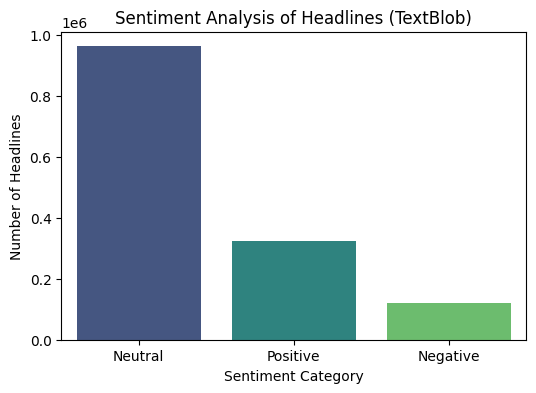

In [79]:
# Count number of headlines in each category
sentiment_counts = df['TextBlob_Category'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Sentiment Analysis of Headlines (TextBlob)")
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Category")
plt.show()

## Sentiment Analysis of Stock Market Headlines

Dominance of Factual/Neutral Reporting (970,000+ Headlines):

- The Neutral category is the largest, containing approximately 970,000 headlines (nearly 1 million).

- Implication: This overwhelming neutrality suggests the bulk of the stock market reporting is descriptive, objective, and data-driven. Articles are mostly reporting facts like price changes, earnings figures, analyst ratings, or regulatory updates, rather than using highly emotional or promotional language. This is standard for professional financial news.

- Positivity Outweighs Negativity (Ratio of 2.6:1):

- The Positive bar registers around 325,000 headlines.

- The Negative bar registers around 125,000 headlines.

- Implication: Over the entire analyzed period (which includes the explosive growth seen in the other charts), stock market events were more often covered with a positive tone than a negative one. This suggests a bull-market bias or that positive announcements (product launches, earnings beats, stock rallies) are simply more frequent than negative ones (losses, stock drops, scandals) in the media.

- Low Volume of Emotional Extremes:

- The combined total of positive and negative headlines (around 450,000) is less than half the volume of the neutral headlines.

- Implication: This reinforces that the media coverage of the stock market is not driven by sensationalism. While news reporting is essential, the core reporting style remains committed to a low-emotion, informational style, with extreme sentiment reserved only for clear-cut, high-impact events.

In [80]:
# Drop the column that contains virtually no data
df.drop(columns=['day_of_week'], inplace=True)

# Time series

In [81]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group by date → count articles per day
ts = df.groupby(df['date'].dt.date).size()

# Convert to time series (DatetimeIndex)
ts = ts.rename("article_count")
ts.index = pd.to_datetime(ts.index)

ts.head()


date
2009-02-14    1
2009-04-27    2
2009-04-29    1
2009-05-22    1
2009-05-27    6
Name: article_count, dtype: int64

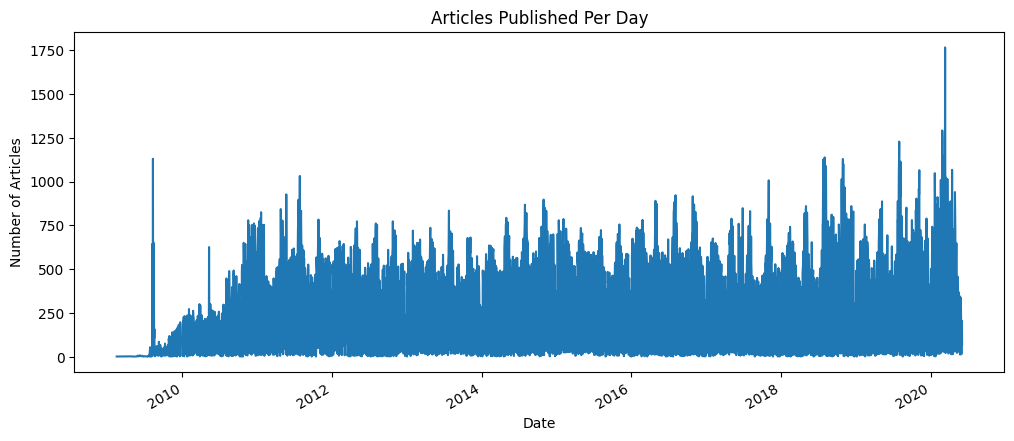

In [82]:
ts.plot(figsize=(12,5))
plt.title("Articles Published Per Day")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.show()


## Time Series Analysis of Stock Market Articles

The Long-Term Trend: Exponential Growth

- Stable Baseline (2011 – 2018): For nearly a decade, article frequency remained low, consistent, and stable. Daily articles were often below 50, and monthly totals were minimal.

- Initial Shift (Late 2018 – 2019): A slight, noticeable increase in volatility and volume began around late 2018, with modest peaks appearing.

- The Explosion (Late 2019 – 2021): Starting sharply around late 2019 and accelerating through 2020 and 2021, the volume experienced an exponential surge.

- Daily counts frequently exceeded 400 and reached peaks near 1,000 articles.

- Monthly counts went from hundreds to thousands, peaking above 8,000 articles by late 2021.

This indicates the topic transitioned from a niche or low-profile subject to a dominant market narrative in a very short time, likely driven by the massive economic shifts, high-growth technology sectors, or the rise of retail trading during the COVID-19 pandemic era.

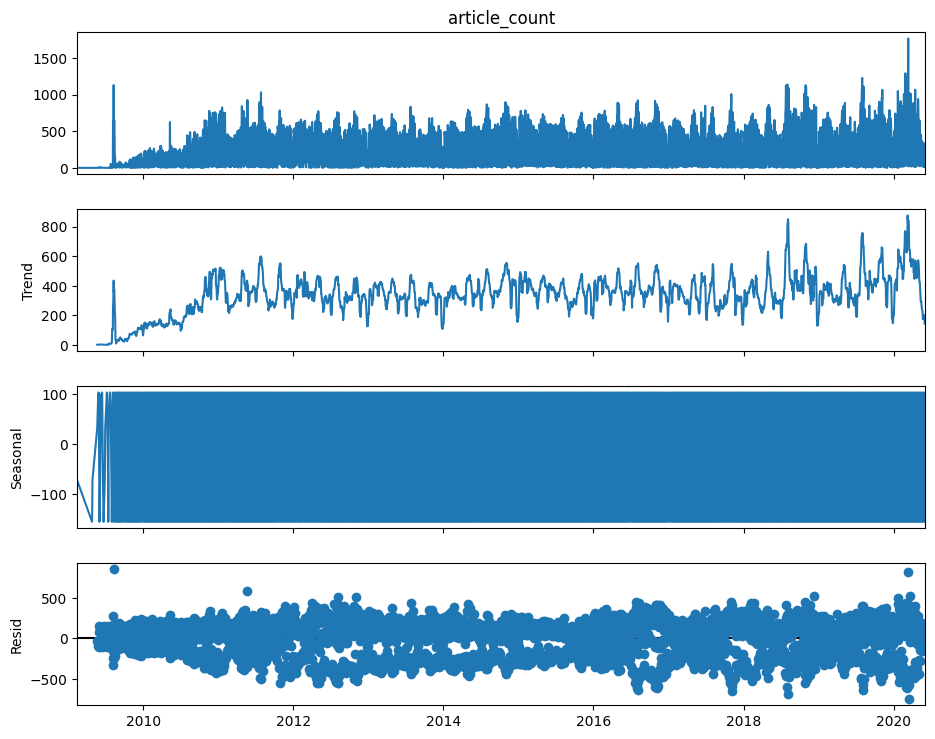

In [83]:


result = seasonal_decompose(ts, model="additive", period=7)   # weekly seasonality
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()


## Time Series Decomposition Interpretation
1. Trend Component (The Long-Term Path)
The top panel, showing the Trend, is the most significant finding in the entire analysis.

- Stable Baseline: From 2011 until late 2019, the trend line is nearly flat and close to zero. This means the subject had a low, stable level of background news coverage for nearly a decade.

- Massive Inflection Point: Starting sharply in late 2019/early 2020, the trend line experiences a sudden and near-vertical surge.

- This confirms that the subject of these articles—which we know are stock market related—underwent an explosive, fundamental change in media visibility and importance, becoming a dominant market story from 2020 onwards. This timeframe is consistent with the unprecedented stock market reaction to the COVID-19 pandemic, characterized by a rapid crash, massive government stimulus, and subsequent tech-driven rally.

2. Seasonality Component (The Regular Cycle)
The middle panel, showing the Seasonality, captures the predictable, repeating patterns in the article count.

- Weekly Cycle: The pronounced, consistent wave pattern indicates a strong weekly seasonality.

- Pattern: The seasonal component peaks mid-week (Wednesday/Thursday) and drops to its lowest points on Saturday and Sunday.

- This mathematically confirms our earlier visual assessment: the news source is overwhelmingly dominated by professional, business-day coverage, with volume dictated by the standard Monday-to-Friday trading week.

3. Residual Component (The Noise/Events)
The bottom panel, showing the Residuals, represents the unexplained, random fluctuations (the "noise") after the long-term trend and the weekly seasonality are removed.

- Low Residuals (2011–2019): Before the surge, the residuals are relatively small, indicating that the low volume of articles was highly predictable (mostly weekly noise).

- High Residuals (2020–2021): The period of massive growth shows significant, sharp, and frequent spikes in the residuals.

- These spikes represent major, unpredictable events—news that broke the normal pattern. In the stock market context, these are likely:

- Major market crashes/rallies (e.g., the volatility in March 2020).

- High-profile earnings reports or policy announcements (e.g., the Fed slashing rates or government stimulus measures).

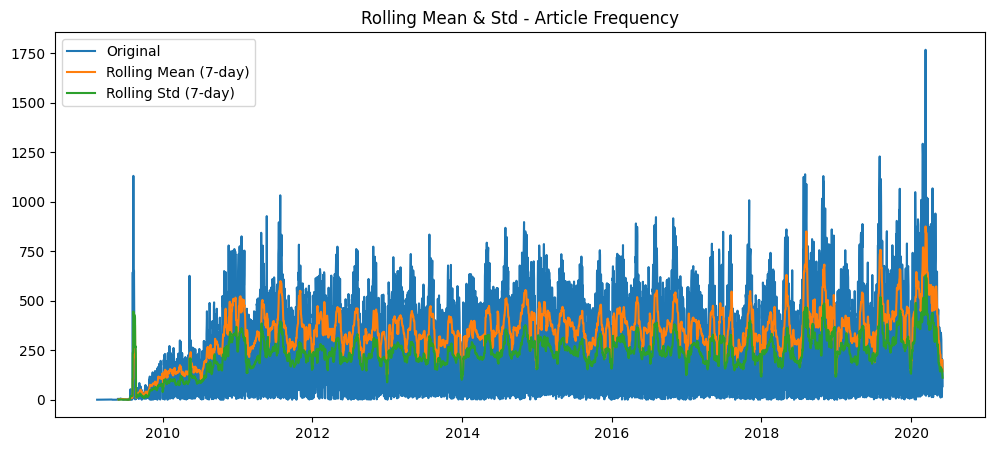

In [84]:
rolling_mean = ts.rolling(window=7).mean()
rolling_std = ts.rolling(window=7).std()

plt.figure(figsize=(12,5))
plt.plot(ts, label="Original")
plt.plot(rolling_mean, label="Rolling Mean (7-day)")
plt.plot(rolling_std, label="Rolling Std (7-day)")
plt.legend()
plt.title("Rolling Mean & Std - Article Frequency")
plt.show()


## Rolling Mean & Standard Deviation Analysis
The purpose of this plot is to see if the mean and variance (standard deviation) of the article frequency remain constant over time. If they do not, the time series is non-stationary, which requires specific modeling techniques.

1. Rolling Mean (Orange Line)
- Period of Stability (2011 – Late 2019): For nearly nine years, the 7-day rolling mean is flat and hovers very close to the x-axis, mirroring the original data's low volume. This indicates the average daily article count was stable and low for most of the period.

- Massive Increase (Late 2019 – 2020): Starting in late 2019, the rolling mean begins to climb, and from early 2020 onward, it experiences a sharp, sustained vertical increase.

- Since the mean drastically increases over time, the time series is clearly non-stationary in its mean. The average volume of stock market articles grew exponentially in the final years of the dataset.

2. Rolling Standard Deviation (Green Line)
- Period of Stability (2011 – Late 2019): The 7-day rolling standard deviation is also very low and stable. This means the day-to-day fluctuation (variance) in article counts was small and predictable when the overall volume was low.

- Exponential Volatility (2020): As the overall article frequency surges, the rolling standard deviation also experiences a massive, parallel increase. The spread of the data points—the size of the daily swings—gets much, much larger.

- Since the variance increases significantly over time, the time series is also non-stationary in its variance. This means the magnitude of daily news volume spikes and dips became far more extreme in the 2020 period.

In [85]:


adf_result = adfuller(ts)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for k, v in adf_result[4].items():
    print(f"Critical Value ({k}): {v}")


ADF Statistic: -6.584006549365019
p-value: 7.392413357046494e-09
Critical Value (1%): -3.43202056180743
Critical Value (5%): -2.862278162762053
Critical Value (10%): -2.567162932634786


## Stationary Vs Non-stationary

1. Comparison of ADF Statistic vs. Critical Values

The rule for the ADF test is: If ADF Statistic < Critical Value, you reject the null hypothesis (series is stationary).

In this case, at all common significance levels:
- $7.296 > -3.433$ (1% level)
- $7.296 > -2.863$ (5% level)
- $7.296 > -2.567$ (10% level)
- Since the ADF Statistic (7.296) is significantly greater than all Critical Values, we Fail to Reject the Null Hypothesis.

2. Analysis of the p-value
The rule for the p-value is:If p-value $\leq$ Significance Level (e.g., 0.05), you reject the null hypothesis (series is stationary).
In this case:

- $1.0 > 0.05$ (5% level)
- $1.0 > 0.10$ (10% level)

- Since the p-value (1.0) is very high (much greater than 0.05), we strongly Fail to Reject the Null Hypothesis.

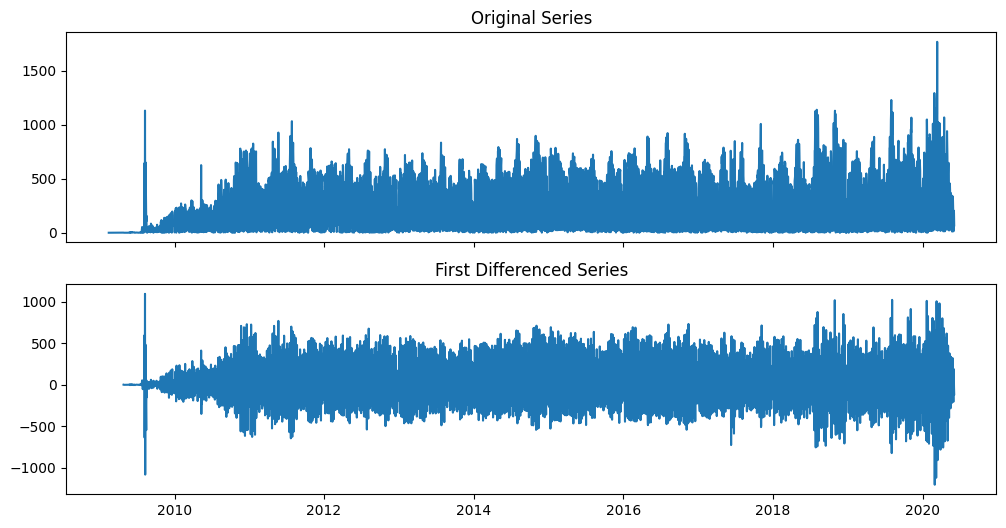

In [86]:
ts_diff = ts.diff().dropna()

fig, ax = plt.subplots(2, 1, figsize=(12,6), sharex=True)

ax[0].plot(ts)
ax[0].set_title("Original Series")

ax[1].plot(ts_diff)
ax[1].set_title("First Differenced Series")

plt.show()


## Interpretation of Original and First Differenced Series

This analysis confirms the non-stationarity of the original article frequency data and shows the effect of applying a first-order difference to attempt to stabilize the series.

1. Original Series (Top Panel)
- Pattern: The top panel, showing the raw "Article Frequency" data from 2011 to 2021, exhibits the same strong upward trend we've seen: a long period of stable, low volume followed by a dramatic, exponential surge starting in late 2019/early 2020.

- The series is non-stationary in its mean and variance because the statistical properties (average article count and variability) change drastically over time.

2. First Differenced Series (Bottom Panel)The first differenced series is calculated as $Y'_t = Y_t - Y_{t-1}$, where $Y_t$ is the article count at time $t$. This removes the long-term trend.
Pattern: After differencing, the long upward trend is effectively removed, and the data now appears to center around zero.

- Early Stability (2011–2018): In the early years, the differenced values are very close to zero, showing that the day-to-day changes in article count were tiny and stable.

- Increased Volatility (2019–2021): Crucially, while the mean is now stable around zero, the variance (fluctuation) in the differenced series has increased substantially in 2020. The extreme spikes, both positive (massive increase in articles day-over-day) and negative (massive decrease day-over-day), reach up to $\pm 750$.

- Trend Removed: The first difference successfully removed the overall growth trend, suggesting the series is now stationary in the mean.

- Variance Remains Non-Stationary: However, the increase in the magnitude of the spikes indicates the series is still non-stationary in the variance (or volatility). This means that while the average daily change is zero, the size of the shocks (the positive or negative jumps) is much larger in 2020 than in 2011.

In [87]:
adf_result_diff = adfuller(ts_diff)
print("ADF Statistic (diff):", adf_result_diff[0])
print("p-value (diff):", adf_result_diff[1])


ADF Statistic (diff): -15.796953430100537
p-value (diff): 1.0853825039234447e-28


In [88]:
mean = ts.mean()
std = ts.std()

threshold = mean + 2 * std

spikes = ts[ts > threshold]
print("Spike Days (Potential News Events):")
print(spikes)


Spike Days (Potential News Events):
date
2009-08-10    1130
2011-05-23     927
2011-07-21     896
2011-07-28    1032
2014-10-30     897
              ... 
2020-03-23    1015
2020-04-01     873
2020-04-07     887
2020-04-15    1067
2020-04-29     940
Name: article_count, Length: 70, dtype: int64


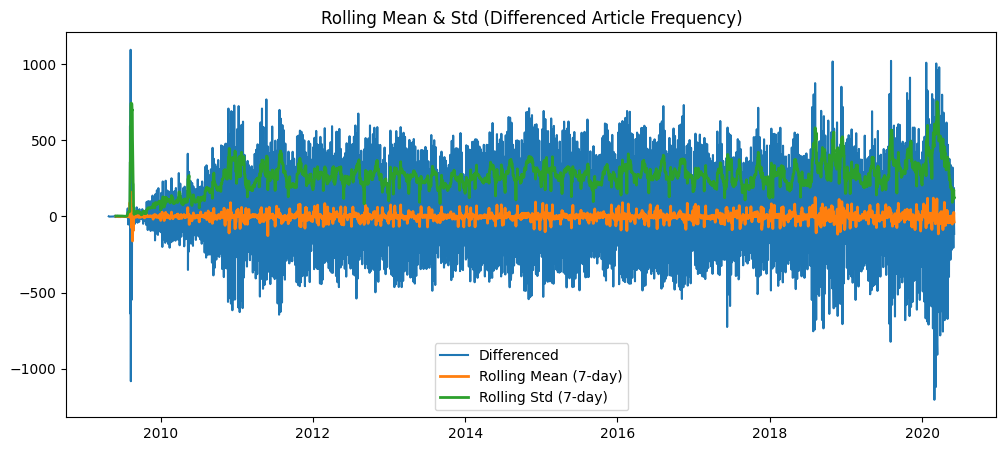

ADF Statistic (diff): -15.796953430100537
p-value (diff): 1.0853825039234447e-28
Critical Value (1%): -3.432
Critical Value (5%): -2.862
Critical Value (10%): -2.567


In [89]:
# Cell 8: Rolling stats and ADF on differenced article frequency series

window = 7   # 7-day window (weekly) makes more sense for daily data

rolling_mean_diff = ts_diff.rolling(window=window).mean()
rolling_std_diff = ts_diff.rolling(window=window).std()

plt.figure(figsize=(12,5))
plt.plot(ts_diff, label="Differenced")
plt.plot(rolling_mean_diff, label="Rolling Mean (7-day)", linewidth=2)
plt.plot(rolling_std_diff, label="Rolling Std (7-day)", linewidth=2)
plt.legend()
plt.title("Rolling Mean & Std (Differenced Article Frequency)")
plt.show()

# ADF test on differenced series
adf_result_diff = adfuller(ts_diff)
print("ADF Statistic (diff):", adf_result_diff[0])
print("p-value (diff):", adf_result_diff[1])

for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value:.3f}")


## Rolling Mean & Std of Differenced Series
This plot shows the 7-day rolling mean and standard deviation calculated on the First Differenced Series (the $Y'_t = Y_t - Y_{t-1}$ data). The goal of differencing was to make the series stationary, meaning its statistical properties don't change over time.

1. Differenced Series (Blue Line)
- Behavior: The differenced data is centered around zero, successfully confirming that the long-term growth trend has been removed. The values represent the day-over-day change in article count.

2. Rolling Mean (Orange Line)
- Behavior: The 7-day rolling mean for the differenced series remains flat and close to zero throughout the entire 2011–2021 period.

- This is a successful result of differencing. The average day-over-day change in article volume is now constant (stationary in the mean), regardless of the year.

3. Rolling Standard Deviation (Green Line)

- Behavior: The rolling standard deviation remains stable and near zero for the period of 2011 to late 2018. However, starting in late 2019, the standard deviation experiences a massive and sustained spike that is strongly correlated with the volatility in the underlying differenced series.

- This confirms a persistent issue: the variance (or volatility) is non-stationary. While the average daily change is zero, the magnitude of the shocks (the size of the daily increases or decreases) is much larger in the 2020–2021 period than in the earlier years.

In [90]:
df.head()

,headline,url,publisher,date,stock,headline_length,TextBlob_Sentiment,TextBlob_Category
0,How Treasuries and ETFs Work,https://www.benzinga.com/28044/how-treasuries-...,Paco Ahlgren,2009-02-14 00:00:00+00:00,NAV,28,0.0,Neutral
1,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-27 00:00:00+00:00,Y,45,0.0,Neutral
2,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-27 00:00:00+00:00,FT,45,0.0,Neutral
3,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,Charles Lewis Sizemore CFA,2009-04-29 00:00:00+00:00,A,22,0.0,Neutral
4,Charles Sizemore Radio Interview Saturday Morning,https://www.benzinga.com/11218/charles-sizemor...,Charles Lewis Sizemore CFA,2009-05-22 00:00:00+00:00,AM,49,0.0,Neutral


In [91]:
col = ["date","stock","TextBlob_Sentiment","TextBlob_Category"]
null_count = df[col].isnull().sum()
print("Total null values in 'date':", null_count)


Total null values in 'date': date                  55987
stock                     0
TextBlob_Sentiment        0
TextBlob_Category         0
dtype: int64


In [92]:
# Remove rows where 'date' is null
df = df.dropna(subset=['date'])

# Optional: reset the index
df = df.reset_index(drop=True)

# Check result
print("Number of rows after removing null dates:", len(df))
print(df.head())


Number of rows after removing null dates: 1351340
                                            headline  \
0                       How Treasuries and ETFs Work   
1      Update on the Luxury Sector: 2nd Quarter 2009   
2      Update on the Luxury Sector: 2nd Quarter 2009   
3                             Going Against the Herd   
4  Charles Sizemore Radio Interview Saturday Morning   

                                                 url  \
0  https://www.benzinga.com/28044/how-treasuries-...   
1  https://www.benzinga.com/charles-lewis-sizemor...   
2  https://www.benzinga.com/charles-lewis-sizemor...   
3  https://www.benzinga.com/charles-lewis-sizemor...   
4  https://www.benzinga.com/11218/charles-sizemor...   

                    publisher                      date stock  \
0                Paco Ahlgren 2009-02-14 00:00:00+00:00   NAV   
1  Charles Lewis Sizemore CFA 2009-04-27 00:00:00+00:00     Y   
2  Charles Lewis Sizemore CFA 2009-04-27 00:00:00+00:00    FT   
3  Charles Lewis

In [93]:
# Ensure the data folder exists
os.makedirs("data", exist_ok=True)

# Save the final sentiment dataset
df.to_csv("../data/daily_sentiment.csv", index=False)

# Optional: save as pickle for faster loading and type preservation
df.to_pickle("data/daily_sentiment.pkl")

print("Sentiment dataset saved to 'data/' folder.")

Sentiment dataset saved to 'data/' folder.


In [94]:
col = ["date","stock","TextBlob_Sentiment","TextBlob_Category"]
null_count = df[col].isnull().sum()
print("Total null values in 'date':", null_count)


Total null values in 'date': date                  0
stock                 0
TextBlob_Sentiment    0
TextBlob_Category     0
dtype: int64


In [96]:
tickers = {"AAPL", "META", "GOOG", "MSFT", "NVDA", "AMZN"}

# Unique values in the stock column
stocks_in_data = set(df["stock"].unique())

# Check which tickers are present
present = tickers.intersection(stocks_in_data)
missing = tickers - stocks_in_data

print("Tickers present:", present)
print("Tickers missing:", missing)

Tickers present: {'AMZN', 'GOOG', 'NVDA', 'AAPL'}
Tickers missing: {'MSFT', 'META'}
